# Recognize ages and gender based on VGG Face embeddings

**Materials:**
- [Adience face dataset](https://talhassner.github.io/home/projects/Adience/Adience-data.html), 'adiencedb:adience'
- [Transfer learning with VGGFace for age/gender classification](https://arxiv.org/pdf/1811.07344.pdf)
- [VGGFace on Adience dataset](https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf)
- [VGGFace model repo](https://github.com/cydonia999/VGGFace2-pytorch)

**Aprroach:**
1. Get VGGFace model
2. Train and validate on Adience dataset
3. Get manual estimation of proprietary data

In [1]:
import torch
import pickle
import sys, os

import importlib

In [2]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [3]:
train_utils = importlib.import_module('src.age_gender.train_utils', project_dir)

In [4]:
%load_ext autoreload

%autoreload 2

### Load VGG Face model

In [5]:
weights_path = '../models/external/resnet50_ft_weight.pkl'

vggface = train_utils.load_vggface_model('resnet', project_dir, weights_path).cuda()

print(vggface)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

### Load Data


In [6]:
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [7]:
plot = importlib.import_module('src.rgutils.plot', project_dir)
adience = importlib.import_module('src.age_gender.adience_utils', project_dir)

In [8]:
DATA_DIR = '../data/external/adience/faces/'
labels_dir = '../data/external/adience/'

##### Create data loaders

In [9]:
num_folds = 5
fold_indices = list(range(num_folds))

In [10]:
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(224),
#     transforms.ToTensor(),
])


In [11]:
age_dataset = train_utils.AdienceDataset(fold_indices, 'age', labels_dir, DATA_DIR,
                                         img_transforms,labels2int=False)
gender_dataset = train_utils.AdienceDataset(fold_indices, 'gender', labels_dir, DATA_DIR,
                                            img_transforms,labels2int=False)

In [12]:
len(age_dataset), len(gender_dataset)

(15269, 17492)

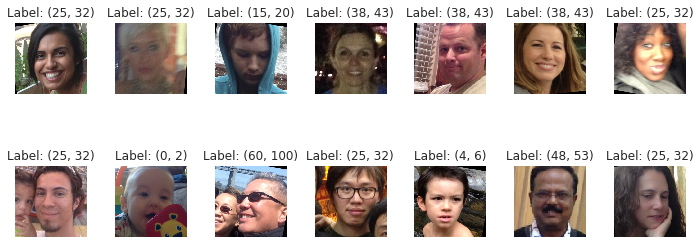

In [13]:
plot.image_labels_grid(2, 7, age_dataset, fig_dims=(12, 5))

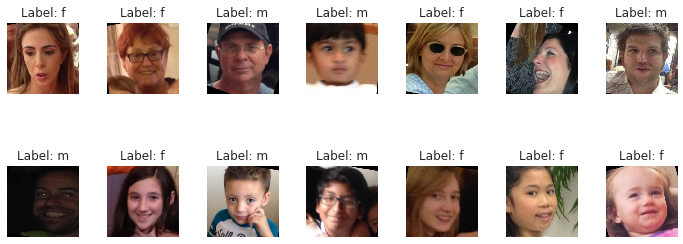

In [14]:
plot.image_labels_grid(2, 7, gender_dataset, fig_dims=(12, 5))

##### Test loader

In [15]:
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.45, 0.44, 0.49], [0.25, 0.22, 0.24]),
])

In [16]:
loader = DataLoader(train_utils.AdienceDataset(fold_indices, 'gender', labels_dir,  DATA_DIR, img_transforms),
                    batch_size=10, shuffle=True, num_workers=4)

In [17]:
for x, y in loader:
    print(x.size())
    print(x.mean(0).mean((1,2)))
    print(np.unique(y, return_counts=True))
    break

torch.Size([10, 3, 224, 224])
tensor([ 0.0358, -0.2918, -0.6160])
(array([0, 1]), array([4, 6]))


### Training parameters

In [18]:
from copy import deepcopy
from torch import optim
import torch.nn as nn

In [19]:
torch_utils = importlib.import_module('src.rgutils.torch', project_dir)

In [20]:
device = torch.device('cuda')

### Training

In [21]:
from sklearn.model_selection import KFold

In [22]:
kf = KFold(n_splits=5)

cv_folds = [{'train': list(t_i), 'val': list(v_i)} for t_i,v_i in kf.split(fold_indices)]

print(cv_folds)

[{'train': [1, 2, 3, 4], 'val': [0]}, {'train': [0, 2, 3, 4], 'val': [1]}, {'train': [0, 1, 3, 4], 'val': [2]}, {'train': [0, 1, 2, 4], 'val': [3]}, {'train': [0, 1, 2, 3], 'val': [4]}]


In [23]:
def cross_validated_training(cv_folds, eta, num_epoch, warmup_epochs, num_classes, label, 
                             input_transforms, input_size, early_stopping=None):
    cv_models = {}
    cv_hist = {}
    max_scores = []
    for i,fold in enumerate(cv_folds):
        print('=*='*15, 'Fold', i, '=*='*15)
        # data loaders
        train_loader = DataLoader(train_utils.AdienceDataset(fold['train'], label, labels_dir, DATA_DIR,
                                                             input_transforms), 
                                  batch_size=BATCH_SIZE, num_workers=4, )
        val_loader = DataLoader(train_utils.AdienceDataset(fold['val'], label, labels_dir, DATA_DIR,
                                                           input_transforms), 
                                  batch_size=BATCH_SIZE, num_workers=4, )
        print(f'Traing on {len(train_loader.dataset)}, validating on {len(val_loader.dataset)} examples')
        # net
        model = train_utils.create_model(vggface, num_classes, device, trainable_layers=['fc'])
        # warm up training
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), eta)
        if label == 'age':
            clf_type = 'multi'
            criterion = nn.CrossEntropyLoss()
        else:
            clf_type = 'binary'
            criterion = nn.BCEWithLogitsLoss()
        trainer = torch_utils.Trainer(clf_type, model, optimizer, criterion, device,
                                      input_size, train_loader, val_loader, tqdm_off=True)
        model,history = trainer.run_training(warmup_epochs, ['accuracy'],
                                             print_stats=False,)
        ckpt = model.state_dict()
        score_max = max(history['val_accuracy'])
        print(f'Max val accuracy {score_max:.2f} at warmup')
        # full training
        model = train_utils.create_model(vggface, num_classes, device, )
        model.load_state_dict(ckpt)
        optimizer = optim.SGD(model.parameters(), eta * 0.5)
        trainer = torch_utils.Trainer(clf_type, model, optimizer, criterion, device,
                                      input_size, train_loader, val_loader, tqdm_off=True)
        model,history = trainer.run_training(num_epoch, ['accuracy'], early_stopping,
                                             history=history,print_stats=False,)
        # best result and save models
        score_max = max(history['val_accuracy'])
        print(f'Max val accuracy {score_max:.2f} at full-scale training')
        cv_models[i] = model
        cv_hist[i] = history
        max_scores.append(score_max)
        del model, trainer
        torch.cuda.empty_cache()
    print('Mean score', np.mean(max_scores), '+-', np.std(max_scores))
    return cv_models, cv_hist


### Train and evaluate ages

In [24]:
input_size = (3,224,224)
eta = 0.001
NUM_EPOCH = 50
EARLY_STOP = 5
WARMUP = 5
N_CLASSES = 8
BATCH_SIZE = 64
cv_models,cv_hist = cross_validated_training(cv_folds, eta, NUM_EPOCH, WARMUP,
                                             N_CLASSES, 'age', 
                                             img_transforms, input_size,
                                             early_stopping=EARLY_STOP)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 0 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 11105, validating on 4164 examples


/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Max val accuracy 67.94 at warmup
Early stopping at 16 epoch
Max val accuracy 72.21 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 1 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 12776, validating on 2493 examples
Max val accuracy 48.30 at warmup
Early stopping at 14 epoch
Max val accuracy 54.99 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 2 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 12459, validating on 2810 examples
Max val accuracy 64.31 at warmup
Early stopping at 11 epoch
Max val accuracy 66.73 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 3 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 12803, validating on 2466 examples
Max val accuracy 46.67 at warmup
Early stopping at 18 epoch
Max val accuracy 53.49 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 4 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 11933, validating on 3336 examples


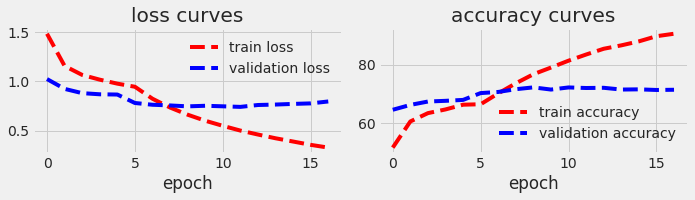

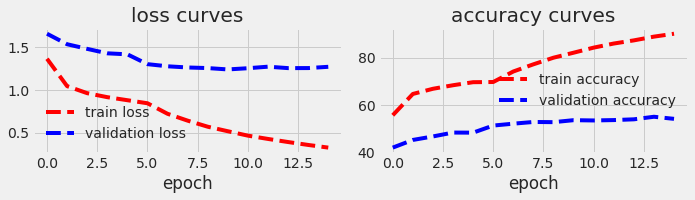

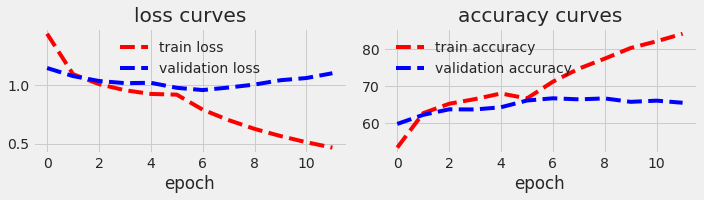

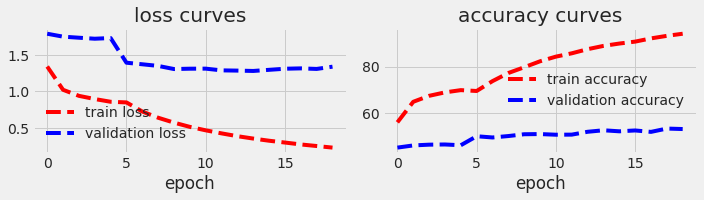

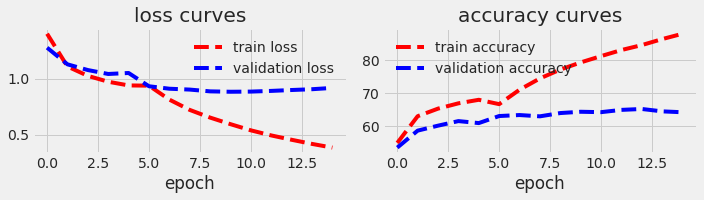

In [25]:
for _,hist in cv_hist.items():
    plot.plot_learning_curve(hist, metrics=['loss','accuracy'], grid=(1,2), fig_shape=(10,3))

##### Save cv models

In [26]:
save_path = '../models/age_gender/vgg_age_cv{index}.hdf'

In [27]:
for i,mdl in cv_models.items():
    torch.save(mdl.state_dict(), save_path.format(index = i))

### Train and evaluate genders

In [28]:
input_size = (3,224,224)
eta = 0.001
NUM_EPOCH = 50
EARLY_STOP = 5
N_CLASSES = 1
WARMUP = 5
BATCH_SIZE = 64
cv_models,cv_hist = cross_validated_training(cv_folds, eta, NUM_EPOCH, WARMUP,
                                             N_CLASSES, 'gender', 
                                             img_transforms, input_size,
                                            early_stopping=EARLY_STOP)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 0 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 13497, validating on 3995 examples


/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Max val accuracy 82.25 at warmup
Early stopping at 14 epoch
Max val accuracy 87.51 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 1 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 13883, validating on 3609 examples
Max val accuracy 90.39 at warmup
Early stopping at 20 epoch
Max val accuracy 94.29 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 2 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 14355, validating on 3137 examples
Max val accuracy 85.43 at warmup
Early stopping at 21 epoch
Max val accuracy 89.35 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 3 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 14186, validating on 3306 examples
Max val accuracy 83.94 at warmup
Early stopping at 14 epoch
Max val accuracy 89.99 at full-scale training
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 4 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Traing on 14047, validating on 3445 examples


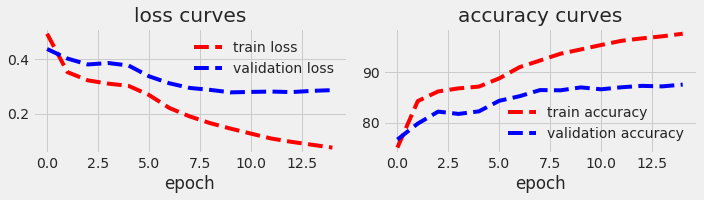

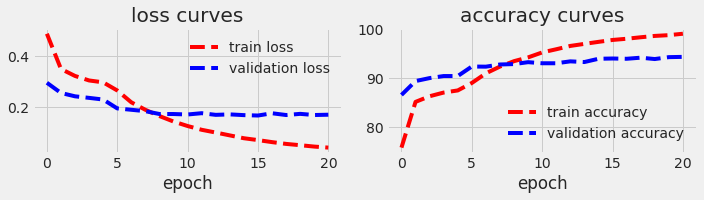

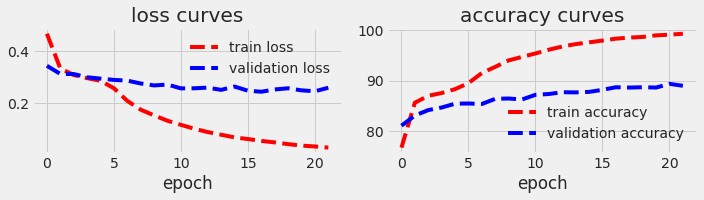

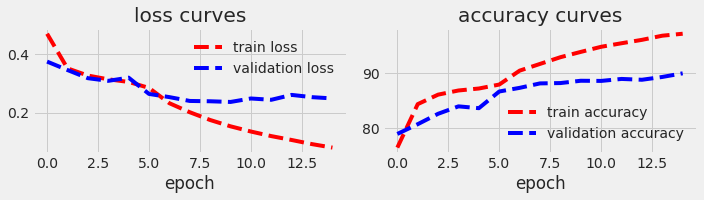

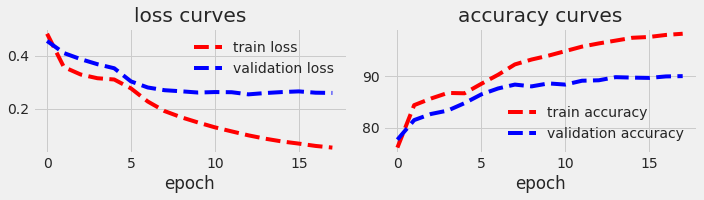

In [29]:
for _,hist in cv_hist.items():
    plot.plot_learning_curve(hist, metrics=['loss','accuracy'], grid=(1,2), fig_shape=(10,3))

##### Save cv models

In [30]:
save_path = '../models/age_gender/vgg_gender_cv{index}.hdf'

In [31]:
for i,mdl in cv_models.items():
    torch.save(mdl.state_dict(), save_path.format(index = i))